In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import shap

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Download

In [ ]:
#Download the dataset using API key
!kaggle datasets download -d abhinand05/daily-sun-spot-data-1818-to-2019

# Unzip the dataset
!unzip daily-sun-spot-data-1818-to-2019.zip -d data/

In [3]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
        plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Data Cleaning

In [4]:
data = pd.read_csv('/kaggle/input/daily-sun-spot-data-1818-to-2019/sunspot_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73718 entries, 0 to 73717
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                73718 non-null  int64  
 1   Year                      73718 non-null  int64  
 2   Month                     73718 non-null  int64  
 3   Day                       73718 non-null  int64  
 4   Date In Fraction Of Year  73718 non-null  float64
 5   Number of Sunspots        73718 non-null  int64  
 6   Standard Deviation        73718 non-null  float64
 7   Observations              73718 non-null  int64  
 8   Indicator                 73718 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 5.1 MB


In [5]:
data.describe()

,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
count,73718.000000,73718.000000,73718.000000,73718.000000,73718.000000,73718.000000,73718.000000,73718.000000,73718.000000
mean,36858.500000,1918.416750,6.518896,15.729347,1918.916406,79.248732,6.924587,4.429678,0.998331
std,21280.697909,58.264401,3.447114,8.800032,58.264520,77.470942,4.778793,7.884112,0.040814
min,0.000000,1818.000000,1.000000,1.000000,1818.001000,-1.000000,-1.000000,0.000000,0.000000
25%,18429.250000,1868.000000,4.000000,8.000000,1868.458500,15.000000,3.000000,1.000000,1.000000
50%,36858.500000,1918.000000,7.000000,16.000000,1918.917500,58.000000,6.600000,1.000000,1.000000
75%,55287.750000,1969.000000,10.000000,23.000000,1969.373250,125.000000,10.000000,1.000000,1.000000
max,73717.000000,2019.000000,12.000000,31.000000,2019.832000,528.000000,77.700000,60.000000,1.000000


In [10]:
# Modified function to print a message if NaN, Inf, or -Inf values are found
def check_and_alert(df):
    is_nan = df.isna().any().any()
    is_inf = np.isinf(df).any().any()
    if is_nan or is_inf:
        print("Data should be cleaned")
    else:
        print("Nan and Inf not found")

# Checking the DataFrame and printing the message if needed
check_and_alert(data)


Nan and Inf not found


In [11]:
# Removing dates with nNumber of sunspots < 0.
data = data[ data['Number of Sunspots'] > 0]

group2 = data.groupby([data['Year'].astype(int),data['Month'].astype(int)]).mean()

sunspots = np.array(group2['Number of Sunspots'].astype(int))
time_step = np.array(group2['Date In Fraction Of Year'])

time = np.arange(sunspots.size)
series = np.array(sunspots)

## Data Visualization

<Figure size 640x480 with 0 Axes>

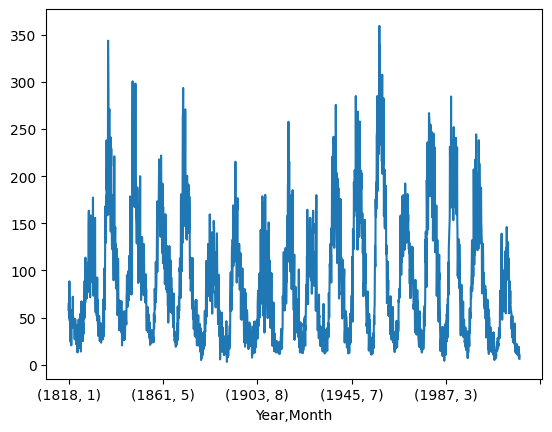

In [13]:
plt.figure()
group2.plot(y = 'Number of Sunspots',legend=False)
plt.show()

In [15]:
# Seasonality

import numpy as np
from scipy.fftpack import fft

def find_cycle_length(data):
    # Apply Fast Fourier Transform
    fft_result = fft(data)
    
    # Compute power spectrum (squared absolute value of FFT components)
    power_spectrum = np.abs(fft_result)**2
    
    # Ignore the zero frequency component for finding the peak
    power_spectrum[0] = 0
    
    # Find the frequency with the maximum power
    peak_frequency_index = np.argmax(power_spectrum)
    
    # Calculate the length of the cycle
    cycle_length = len(data) / peak_frequency_index

    return cycle_length

# Example usage
#data = np.array([...])  # Your numpy array
cycle_length = find_cycle_length(series)
print("Cycle length: %.2f years"%(cycle_length/12))


Cycle length: 11.07 years


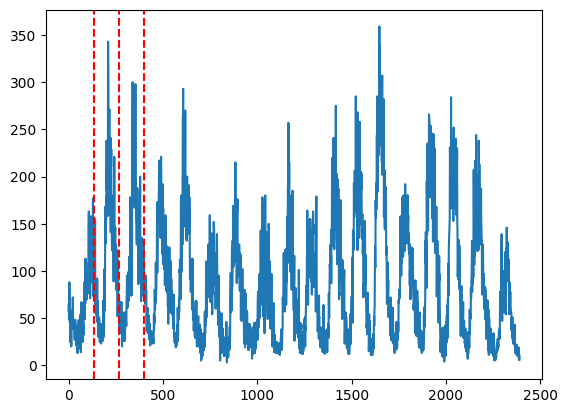

In [17]:
plt.plot(series)
plt.axvline(x=cycle_length, color='r', linestyle='--')
plt.axvline(x=2*cycle_length, color='r', linestyle='--')
plt.axvline(x=3*cycle_length, color='r', linestyle='--')

# Training

## Data Splitting

In [18]:
# Define the split time
split_time = 2000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Training Model

This is training a neural network for the shole training data without removing any seasonality. 
Uses the window function to label features.

In [19]:
def data_window(data_ar, window_size, batch_size, shuffle_buffer):
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(data_ar)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset
    

In [20]:
# Parameters
window_size = 72
batch_size = 64
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = data_window(x_train, window_size, batch_size, shuffle_buffer_size)

### Defining the Model 

In [21]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 72, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 72, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

### Tuning the Learning Rate

In [24]:
init_weights = model.get_weights()

In [26]:
from tqdm.keras import TqdmCallback

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, verbose=0, callbacks=[lr_schedule,TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

(1e-08, 0.001, 0.0, 100.0)

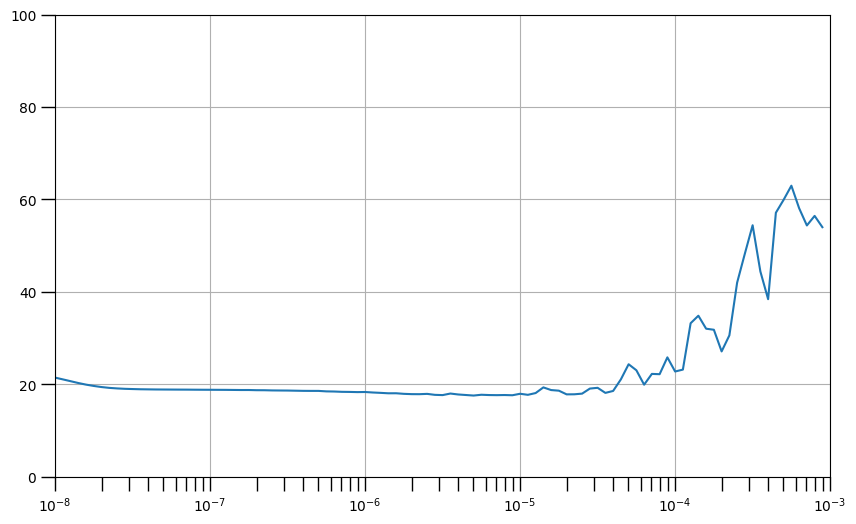

In [27]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

### Fitting the Model

In [28]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [29]:
# Set the learning rate
learning_rate = 3e-5  # Chosen from the Loss vs Learning rate plot

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [30]:
from tqdm.keras import TqdmCallback

# Train the model
history = model.fit(train_set,epochs=500, verbose=0,callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

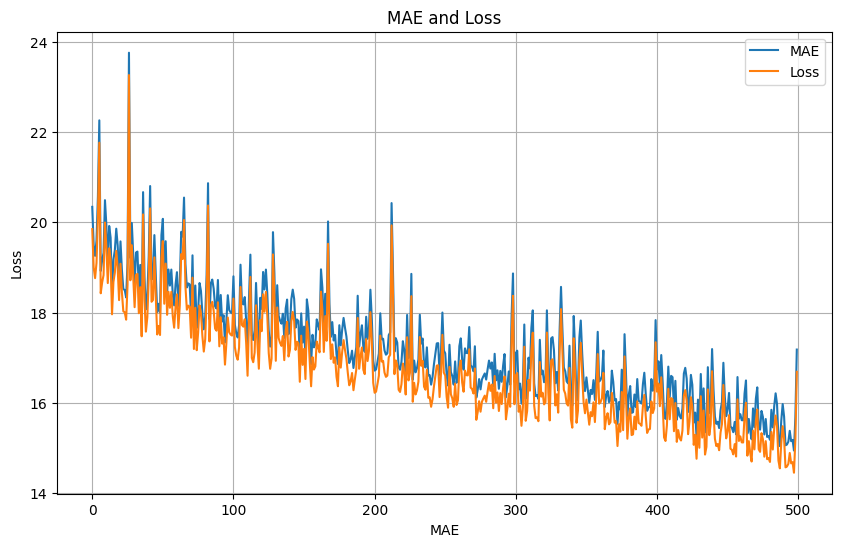

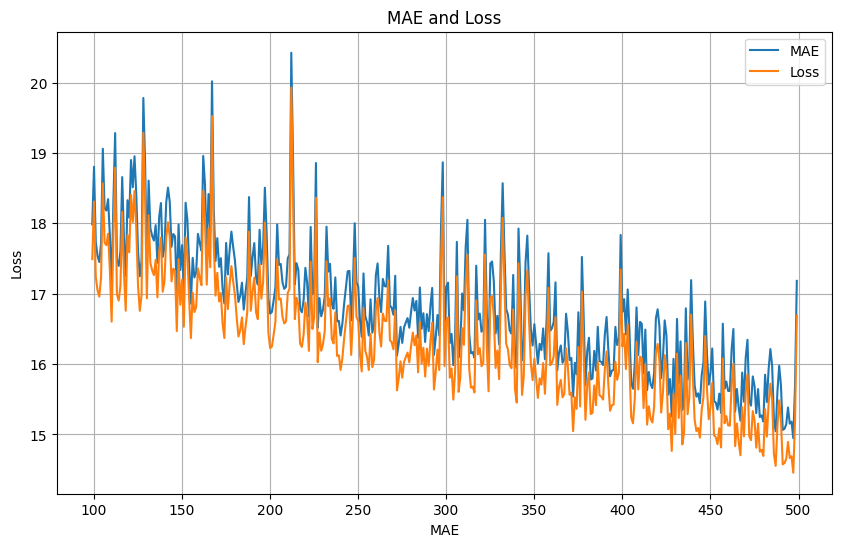

In [31]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [49]:
loss[-1]

16.690263748168945

# Model Prediction

In [32]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

7/7 [==============================] - 1s 21ms/step


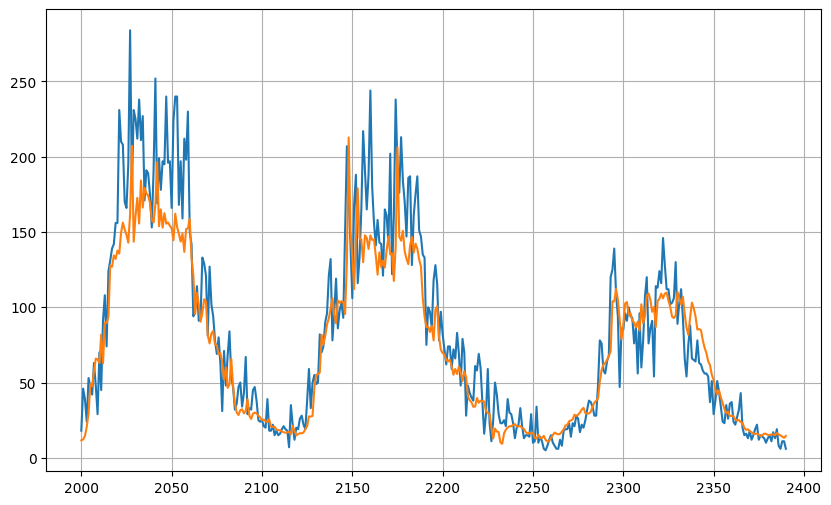

In [33]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [34]:
# Analyzing the predictions --------------------------------------

# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())



17.996109


### Saving the Model

In [37]:
model.save('model1_parameters.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [41]:
import h5py

with h5py.File('model1_parameters.h5', 'a') as f:
    f.attrs['window_size'] = window_size   # Replace with your actual window size
    f.attrs['batch_size'] = batch_size   # Replace with your actual batch size

# Model Analysis

In [44]:
model = tf.keras.models.load_model('model1_parameters.h5')

# Get the optimizer name
optimizer_name = model.optimizer.name

# Get the learning rate
# Note: This assumes a static learning rate. If a learning rate schedule was used, this is more complex.
learning_rate = float(model.optimizer.lr.numpy())

# Get the loss function
loss_function = model.loss

# Get the list of metrics used in the model
metrics = [metric.name for metric in model.metrics]

print(f"Optimizer Name: {optimizer_name}")
print(f"Learning Rate: {learning_rate}")
print(f"Loss Function: {loss_function}")
print(f"Metrics: {metrics}")


Optimizer Name: SGD
Learning Rate: 2.9999999242136255e-05
Loss Function: <keras.src.losses.Huber object at 0x787ae04d12a0>
Metrics: ['loss', 'mae']


In [48]:
model.optimizer.loss

AttributeError: 'SGD' object has no attribute 'loss'

In [ ]:
c = -1
for layer in model.layers:
    c = c+1
    if c<2:
        weights = layer.get_weights()  # List of numpy arrays
        print(f"Weights for layer {layer.name}: {weights}")
    else:
        break